# 02 - Teste de Modelo Único

Este notebook testa um único modelo LLM para detecção de fake news.

## Objetivos
1. Carregar um modelo LLM local
2. Testar diferentes estratégias de prompting
3. Avaliar desempenho em um dataset
4. Analisar resultados e erros

In [1]:
# Configurar path do projeto
import sys
from pathlib import Path
from loguru import logger

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / "src"))

# Configurar logger
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add(project_root / "reports/logs/02_single_model_test.log", rotation="10 MB")

logger.info(f"Project root: {project_root}")

Project root: /Users/joaoroldi/Projects/tcc2


In [2]:
# Imports
import time
import pandas as pd
import torch
from tqdm.notebook import tqdm

# Módulos do projeto
from config import MODELS, EXPERIMENT_CONFIG
from data.data_loader import load_dataset, prepare_test_set
from models.model_handler import ModelHandler
from models.prompts import PromptBuilder
from models.metrics import calculate_metrics

# Verificar GPU
logger.info(f"CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"VRAM Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

CUDA disponível: False


## 1. Configuração do Experimento

In [3]:
# Configurações
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"  # Modelo mais leve para teste
STRATEGY = "zero_shot"  # Opções: zero_shot, few_shot, chain_of_thought
DATASET_NAME = "fakebr"
SAMPLE_SIZE = 50  # Número de amostras para teste rápido
SEED = 42

logger.info(f"Modelo: {MODEL_NAME}")
logger.info(f"Estratégia: {STRATEGY}")
logger.info(f"Dataset: {DATASET_NAME}")
logger.info(f"Amostras: {SAMPLE_SIZE}")

Modelo: Qwen/Qwen2-1.5B-Instruct
Estratégia: zero_shot
Dataset: fakebr
Amostras: 50


## 2. Carregar Dados

In [4]:
# Carregar dataset
logger.info("Carregando dataset...")
df = load_dataset(DATASET_NAME)

# Preparar conjunto de teste
test_df = prepare_test_set(df, sample_size=SAMPLE_SIZE, seed=SEED)

logger.info(f"\nConjunto de teste: {len(test_df)} amostras")
logger.info(f"Distribuição: {test_df['label'].value_counts().to_dict()}")

Carregando dataset...
Carregando dataset: Fake.Br Corpus
Dataset carregado: 7200 amostras

Conjunto de teste: 50 amostras
Distribuição: {1: 25, 0: 25}


## 3. Carregar Modelo

In [5]:
# Carregar modelo
logger.info("Carregando modelo...")
model_handler = ModelHandler(MODEL_NAME)

# Informações do modelo
model_info = model_handler.get_model_info()
logger.info(f"\nModelo carregado:")
for key, value in model_info.items():
    logger.info(f"  {key}: {value}")

Carregando modelo...
Carregando modelo: Qwen/Qwen2-1.5B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Device set to use cpu


Modelo carregado com sucesso!

Modelo carregado:
  model_name: Qwen/Qwen2-1.5B-Instruct
  num_parameters: 1543714304
  dtype: torch.float16
  device: cpu
  vram_usage_gb: 0.0


## 4. Preparar Prompts

In [ ]:
# Criar construtor de prompts
prompt_builder = PromptBuilder(strategy=STRATEGY)

# Se for few-shot, preparar exemplos
if STRATEGY == "few_shot":
    examples_df = df[~df.index.isin(test_df.index)].sample(
        n=EXPERIMENT_CONFIG["few_shot_examples"],
        random_state=SEED
    )
    prompt_builder.set_examples(examples_df)
    print(f"Exemplos few-shot preparados: {len(examples_df)}")

# Visualizar exemplo de prompt
sample_text = test_df.iloc[0]['text'][:500]
sample_prompt = prompt_builder.build_prompt(sample_text)

print("\n" + "="*60)
print("EXEMPLO DE PROMPT")
print("="*60)
print(sample_prompt[:1000])
print("...")


EXEMPLO DE PROMPT
Você é um especialista em análise de notícias e detecção de desinformação. 
Sua tarefa é analisar notícias em português brasileiro e classificá-las como verdadeiras ou falsas.
Seja objetivo e baseie sua análise apenas no conteúdo fornecido.

Analise a seguinte notícia e classifique-a como "Verdadeira" ou "Falsa".

Notícia:
Tempo de semear. Presidente do Haiti tenta adotar ideias novas num país que precisa desesperadamente delas.  Nos arredores de Desdunes, cidade situada no fértil vale de Artibonite, no Haiti, três escavadeiras trabalham nas margens do lamacento canal de Duclos. À frente das máquinas, o canal não passa de uma incisão cortando o lodo. Atrás delas, está o resultado de seu trabalho: o canal parece largo o bastante para acomodar um navio de guerra. Artibonite é uma região de arrozais, capaz de produzi

Responda apenas com uma palavra: "Verdadeira" ou "Falsa".

Classificação:
...


## 5. Executar Inferência

In [7]:
def extract_prediction(response: str) -> int:
    """Extrai predição da resposta do modelo."""
    response_lower = response.lower().strip()
    
    # Palavras-chave para fake news
    fake_keywords = ["falsa", "fake", "falso", "mentira", "desinformação", "1"]
    # Palavras-chave para notícia verdadeira
    true_keywords = ["verdadeira", "verdadeiro", "real", "verídica", "0"]
    
    # Verificar fake primeiro
    for keyword in fake_keywords:
        if keyword in response_lower:
            return 1
    
    # Verificar verdadeira
    for keyword in true_keywords:
        if keyword in response_lower:
            return 0
    
    return -1  # Não conseguiu determinar

In [8]:
# Executar inferência
predictions = []
responses = []
inference_times = []

logger.info("Executando inferência...\n")

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Classificando"):
    # Construir prompt
    prompt = prompt_builder.build_prompt(row["text"])
    
    # Gerar resposta
    start_time = time.time()
    response = model_handler.generate(prompt)
    end_time = time.time()
    
    # Extrair predição
    prediction = extract_prediction(response)
    
    predictions.append(prediction)
    responses.append(response)
    inference_times.append(end_time - start_time)

# Adicionar ao DataFrame
test_df['prediction'] = predictions
test_df['response'] = responses
test_df['inference_time'] = inference_times 

logger.info(f"\n✅ Inferência concluída!")
logger.info(f"Tempo médio: {sum(inference_times) / len(inference_times):.2f}s por notícia")

Executando inferência...



Classificando:   0%|          | 0/50 [00:00<?, ?it/s]


✅ Inferência concluída!
Tempo médio: 12.26s por notícia


## 6. Avaliar Resultados

In [ ]:
# Calcular métricas
true_labels = test_df['label'].tolist()
pred_labels = test_df['prediction'].tolist()

metrics = calculate_metrics(true_labels, pred_labels)

# Exibir métricas
logger.info("MÉTRICAS DE DESEMPENHO")
logger.info(f"Acurácia:  {metrics['accuracy']:.4f}")
logger.info(f"Precisão:  {metrics['precision']:.4f}")
logger.info(f"Recall:    {metrics['recall']:.4f}")
logger.info(f"F1-Score:  {metrics['f1_score']:.4f}")
logger.info(f"\nPredições inválidas: {metrics['invalid_predictions']} ({metrics['invalid_rate']:.2%})")

MÉTRICAS DE DESEMPENHO
Acurácia:  0.6200
Precisão:  0.6000
Recall:    0.7200
F1-Score:  0.6545

Predições inválidas: 0 (0.00%)


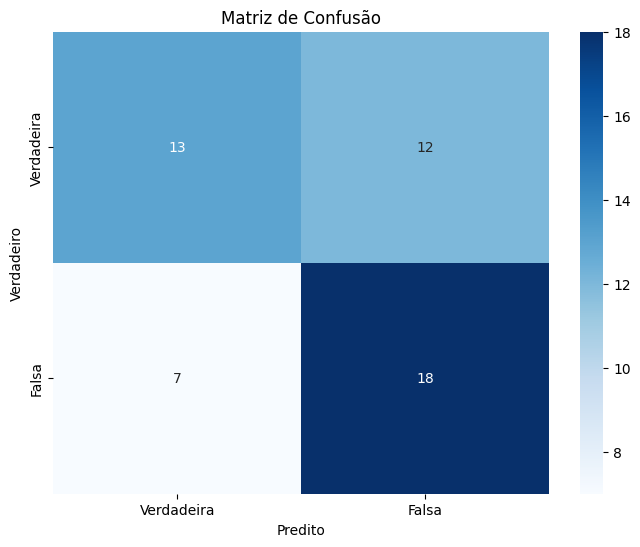

In [10]:
# Matriz de confusão
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics['confusion_matrix']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Verdadeira', 'Falsa'],
            yticklabels=['Verdadeira', 'Falsa'])
ax.set_title('Matriz de Confusão')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Predito')
plt.show()

## 7. Análise de Erros

In [12]:
# Identificar erros
test_df['correct'] = test_df['label'] == test_df['prediction']
errors_df = test_df[~test_df['correct']]

logger.info(f"Total de erros: {len(errors_df)}")
logger.info(f"Taxa de erro: {len(errors_df) / len(test_df):.2%}")

Total de erros: 19
Taxa de erro: 38.00%


In [ ]:
# Analisar um erro (Falso Positivo - classificou como fake mas era verdadeira)
false_positives = errors_df[(errors_df['label'] == 0) & (errors_df['prediction'] == 1)]

if len(false_positives) > 0:
    print("="*60)
    print("EXEMPLO: FALSO POSITIVO")
    print("="*60)
    sample = false_positives.iloc[0]
    print(f"Texto: {sample['text'][:300]}...")
    print(f"\nLabel verdadeiro: {sample['label']} (Verdadeira)")
    print(f"Predição: {sample['prediction']} (Falsa)")
    print(f"\nResposta do modelo: {sample['response']}")

EXEMPLO: FALSO POSITIVO
Texto: Passageira de helicóptero filmou momento exato em que aeronave caiu. Fato aconteceu em Capitólio, MG.  Um helicóptero que estava sobrevoando o município de Capitólio, em Escarpas do Lago, Minas Gerais, sofreu uma queda e deixou 3 pessoas feridas.  O acidente aconteceu na tarde do último domingo (22)...

Label verdadeiro: 0 (Verdadeira)
Predição: 1 (Falsa)

Resposta do modelo: Verdadeira

A notícia é verdadeira porque ela menciona que um helicóptero que estava sobrevoando o município de Capitólio, em Escarpas do Lago, Minas Gerais, sofreu uma queda e deixou 3 pessoas feridas. Além disso, a Anac informou que a aeronave de matrícula PP-MAM estava registrada como privada e "não poderia ofertar serviço de voos panorâmicos" abaixo um vídeo na câmera interna da aeronave. Isso confirma que a informação é real e pode ser verificada através de fontes independentes. Portanto, a notícia é verdadeira. 

No entanto, é importante lembrar que a informação pode estar corr

In [ ]:
# Analisar um erro (Falso Negativo - classificou como verdadeira mas era fake)
false_negatives = errors_df[(errors_df['label'] == 1) & (errors_df['prediction'] == 0)]

if len(false_negatives) > 0:
    print("="*60)
    print("EXEMPLO: FALSO NEGATIVO")
    print("="*60)
    sample = false_negatives.iloc[0]
    print(f"Texto: {sample['text'][:300]}...")
    print(f"\nLabel verdadeiro: {sample['label']} (Falsa)")
    print(f"Predição: {sample['prediction']} (Verdadeira)")
    print(f"\nResposta do modelo: {sample['response']}")

EXEMPLO: FALSO NEGATIVO
Texto: Em reunião na Casa Branca, Trump e Theresa May discutem cooperação. "Acho que o senhor confirmou que está 100% com a Otan", diz premiê britânica sobre Trump..  O presidente americano, Donald Trump, se reuniu nesta sexta-feira (27) com a primeira-ministra britânica, Theresa May, na Casa Branca, em se...

Label verdadeiro: 1 (Falsa)
Predição: 0 (Verdadeira)

Resposta do modelo: Verdadeira

Justificativa: A notícia fornece informações sobre uma reunião entre o presidente americano, Donald Trump, e a primeira-ministra britânica, Theresa May, na Casa Branca. Ela menciona discussões sobre cooperação militar e econômica, bem como sobre o combate ao grupo jihadista Estado Islâmico (EI). Além disso, ela cita declarações específicas de ambas as autoridades sobre suas posições sobre a Otan e a sanção contra a Rússia. Portanto, a informação fornecida é verdadeira.


## 8. Salvar Resultados

In [15]:
# Salvar resultados
from config import PATHS

results_dir = Path(PATHS['results_dir'])
results_dir.mkdir(parents=True, exist_ok=True)

# Salvar DataFrame com predições
output_file = results_dir / f"test_{MODEL_NAME.replace('/', '_')}_{STRATEGY}_{DATASET_NAME}.csv"
test_df.to_csv(output_file, index=False)

logger.info(f"✅ Resultados salvos em: {output_file}")

✅ Resultados salvos em: /Users/joaoroldi/Projects/tcc2/reports/test_Qwen_Qwen2-1.5B-Instruct_zero_shot_fakebr.csv


In [16]:
# Liberar memória
model_handler.unload()
torch.cuda.empty_cache()

logger.info("✅ Modelo descarregado da memória")

Modelo descarregado da memória.
✅ Modelo descarregado da memória


## Conclusões

Analise os resultados acima e documente:
- O modelo teve bom desempenho?
- Quais tipos de erros foram mais comuns?
- A estratégia de prompting foi adequada?
- Próximos passos?